In [1]:
import os
import matplotlib.pyplot as plt
import glob
from PIL import Image
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.callbacks import History 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

Using TensorFlow backend.


In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    zahl = (int(base[8:10])) / 100
    x_data.append(test_image)
    zw = np.array([zahl])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

(2883, 32, 32, 3)
(2883, 1)


In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(16, (5, 5), padding='same'))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dense(8,activation="linear"))
model.add(Dense(1))
model.summary()

def Periodic_Loss(y_true, y_pred):
    dif1 = K.abs(y_pred - y_true)
    dif2 = K.abs(dif1 + K.constant(1))
#    dif3 = K.abs(dif1 + K.constant(-1))
    dif = K.minimum(dif1, dif2)
#    dif = K.minimum(dif, dif3)
    ret = K.mean(K.square(dif), axis=-1)
    return ret

model.compile(loss=Periodic_Loss, optimizer=keras.optimizers.Adadelta(), metrics = ["accuracy"])
#model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adadelta(), metrics = ["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 16)          2320      
_________________________________________________________________
max_

In [4]:
Batch_Size = 8
Epoch_Anz = 20
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
289/289 [==============================] - 9s 30ms/step - loss: 0.0383 - acc: 4.3365e-04 - val_loss: 0.0060 - val_acc: 0.0035
Epoch 2/20
289/289 [==============================] - 8s 26ms/step - loss: 0.0109 - acc: 0.0026 - val_loss: 0.0076 - val_acc: 0.0052
Epoch 3/20
289/289 [==============================] - 10s 34ms/step - loss: 0.0067 - acc: 0.0026 - val_loss: 0.0131 - val_acc: 0.0052
Epoch 4/20
289/289 [==============================] - 14s 48ms/step - loss: 0.0048 - acc: 0.0026 - val_loss: 0.0016 - val_acc: 0.0052
Epoch 5/20
289/289 [==============================] - 13s 46ms/step - loss: 0.0037 - acc: 0.0030 - val_loss: 0.0039 - val_acc: 0.0052
Epoch 6/20
289/289 [==============================] - 14s 48ms/step - loss: 0.0027 - acc: 0.0030 - val_loss: 0.0016 - val_acc: 0.0035
Epoch 7/20
289/289 [==============================] - 13s 47ms/step - loss: 0.0025 - acc: 0.0026 - val_loss: 0.0012 - val_acc: 0.0035
Epoch 8/20
2

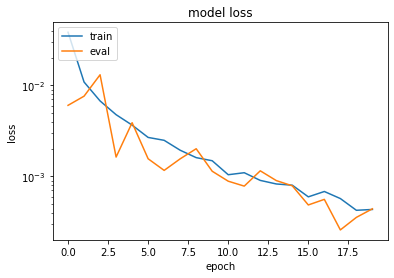

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

In [6]:
Input_dir='data_resize_all'
files = glob.glob(Input_dir + '/*.*')
res = []

for aktfile in files:
    base = os.path.basename(aktfile)
    zahl = (int(base[8:10])) / 100
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    zw1 = zahl
    zw2 = round(classes[0][0], 2)
    zw3 = round(classes[0][0] - zahl, 2)
    zw4a = abs(zw3)
    zw4b = abs(zw3+1)
    zw4c = abs(zw3-1)
    zw4 = zw3
    if zw4b < zw4a: 
        zw4 = zw3+1
        zw4a = zw4b
    if zw4c < zw4a: 
        zw4 = zw3-1
    res.append(np.array([zw1, zw2, zw3, zw4]))
#    print(base, ', ', zw1, ', ', round(zw2, 2), ', ', round(zw3, 2), ', ', round(zw4, 2))

res = np.asarray(res)
statistic = np.array([np.mean(res[:,3]), np.std(res[:,3]), np.min(res[:,3]), np.max(res[:,3])])
print(statistic)
res_step_1 = res

[ 0.004   0.0144 -0.05    0.38  ]


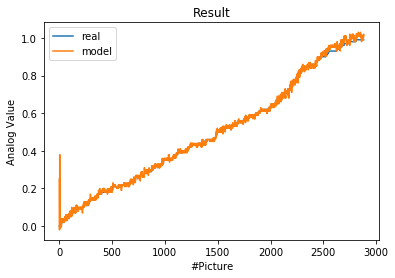

In [7]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Analog Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

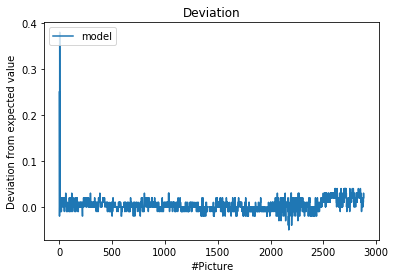

In [8]:
plt.plot(res[:,3])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['model'], loc='upper left')
plt.show()

In [9]:
Batch_Size = 8
Epoch_Anz = 40
Shift_Range = 1
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)

Epoch 1/40
289/289 [==============================] - 15s 50ms/step - loss: 0.0060 - acc: 0.0022 - val_loss: 0.0017 - val_acc: 0.0035
Epoch 2/40
289/289 [==============================] - 15s 53ms/step - loss: 0.0012 - acc: 0.0043 - val_loss: 0.0045 - val_acc: 0.0035
Epoch 3/40
289/289 [==============================] - 15s 51ms/step - loss: 0.0015 - acc: 0.0035 - val_loss: 0.0026 - val_acc: 0.0052
Epoch 4/40
289/289 [==============================] - 15s 52ms/step - loss: 0.0015 - acc: 0.0035 - val_loss: 0.0022 - val_acc: 0.0035
Epoch 5/40
289/289 [==============================] - 15s 53ms/step - loss: 0.0011 - acc: 0.0039 - val_loss: 5.9590e-04 - val_acc: 0.0052
Epoch 6/40
289/289 [==============================] - 15s 53ms/step - loss: 0.0012 - acc: 0.0035 - val_loss: 0.0050 - val_acc: 0.0052
Epoch 7/40
289/289 [==============================] - 15s 50ms/step - loss: 0.0013 - acc: 0.0030 - val_loss: 0.0012 - val_acc: 0.0035
Epoch 8/40
289/289 [==============================] - 15s 

289/289 [==============================] - 8s 28ms/step - loss: 1.6827e-04 - acc: 0.0043 - val_loss: 7.6154e-04 - val_acc: 0.0052
Epoch 37/40
289/289 [==============================] - 8s 28ms/step - loss: 2.3929e-04 - acc: 0.0043 - val_loss: 0.0017 - val_acc: 0.0035
Epoch 38/40
289/289 [==============================] - 8s 27ms/step - loss: 2.9412e-04 - acc: 0.0043 - val_loss: 0.0011 - val_acc: 0.0035
Epoch 39/40
289/289 [==============================] - 8s 29ms/step - loss: 5.0170e-04 - acc: 0.0039 - val_loss: 3.3426e-04 - val_acc: 0.0052
Epoch 40/40
289/289 [==============================] - 10s 35ms/step - loss: 2.1939e-04 - acc: 0.0043 - val_loss: 0.0019 - val_acc: 0.0035


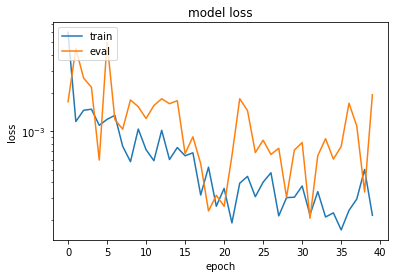

In [10]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

In [11]:
Input_dir='data_resize_all'
files = glob.glob(Input_dir + '/*.*')
res = []

for aktfile in files:
    base = os.path.basename(aktfile)
    zahl = (int(base[8:10])) / 100
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    zw1 = zahl
    zw2 = round(classes[0][0], 2)
    zw3 = round(classes[0][0] - zahl, 2)
    zw4a = abs(zw3)
    zw4b = abs(zw3+1)
    zw4c = abs(zw3-1)
    zw4 = zw3
    if zw4b < zw4a: 
        zw4 = zw3+1
        zw4a = zw4b
    if zw4c < zw4a: 
        zw4 = zw3-1
    res.append(np.array([zw1, zw2, zw3, zw4]))
#    print(base, ', ', zw1, ', ', round(zw2, 2), ', ', round(zw3, 2), ', ', round(zw4, 2))

res = np.asarray(res)
statistic = np.array([np.mean(res[:,3]), np.std(res[:,3]), np.min(res[:,3]), np.max(res[:,3])])
print(statistic)
res_step_1 = res

[-0.0053  0.0163 -0.06    0.32  ]


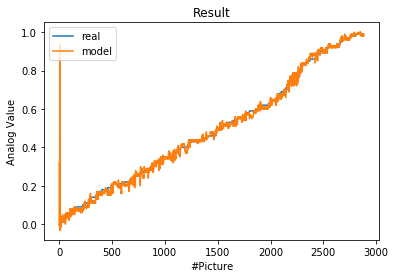

In [12]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Analog Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

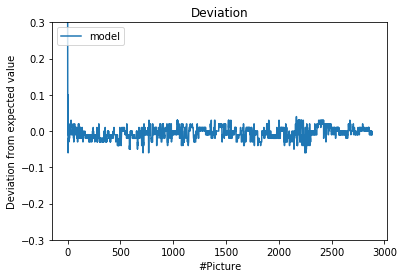

In [17]:
plt.plot(res[:,3])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['model'], loc='upper left')
plt.ylim(-0.3, 0.3)
plt.show()

In [14]:
model.save("test.h5")

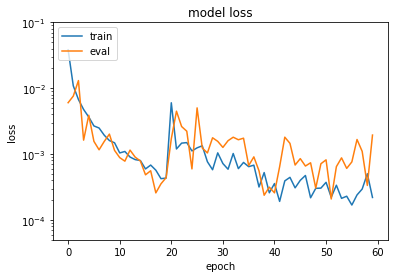

In [15]:
plt.semilogy(loss_ges)
plt.semilogy(val_loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.ylim(1E-1, 5E-5)
plt.show()